# Minimum Fuel Orbit Transfer Optimization

 This notebook addresses the problem of optimizing the trajectory of a spacecraft for a minimum fuel orbit transfer from Low Earth Orbit (LEO) to Geostationary Earth Orbit (GEO). The optimization problem involves determining the optimal thrust and thrust angle profiles that minimize fuel consumption while satisfying the spacecraft's dynamic constraints and boundary conditions.

The key components of the problem include:
- **Dynamics**: The equations governing the spacecrafts motion, including the effects of thrust and gravitational forces.
- **Cost Function**: The objective to minimize, which includes maximizing the final mass of the spacecraft and minimizing the total thrust applied.
- **Equality Constraints**: Conditions that must be met at the start and end of the trajectory, such as initial and final positions and velocities.
- **Inequality Constraints**: Bounds on the control and state variables, such as thrust limits and allowable mass range.

The optimization is performed using the OpenGoddard library, which provides tools for solving trajectory optimization problems. The results include the optimal thrust and thrust angle profiles, as well as the corresponding state trajectories (radial distance, velocities, and mass) over time.

In [11]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics


In [12]:
# Constants
mu = 3.986e14  # Gravitational parameter (m^3/s^2), represents the standard gravitational parameter for Earth.
Isp = 300  # Specific impulse (s), a measure of the efficiency of rocket and jet engines.
g0 = 9.81  # Standard gravity (m/s^2), the nominal gravitational acceleration on Earth's surface.
r_LEO = 6.78e6  # Radius of Low Earth Orbit (LEO) (m), the typical altitude for LEO.
r_GEO = 4.216e7  # Radius of Geostationary Earth Orbit (GEO) (m), the altitude where a satellite orbits Earth with a period equal to Earth's rotation period.
J2 = 1.08263e-3  # Earth's second zonal harmonic, a coefficient that represents the oblateness of the Earth.
R_E = 6378e3  # Earth's radius in meters, the average radius of Earth.


In [13]:
class Spacecraft:
    # Constructor method to initialize the Spacecraft object
    def __init__(self):
        # Specific impulse of the spacecraft's engine (Isp)
        self.Isp = Isp
        # Standard gravitational acceleration (g0)
        self.g0 = g0

In [14]:
def dynamics(prob, obj, section):
    """
    Computes the dynamics of a spacecraft trajectory optimization problem.

    Parameters:
    prob (object): The problem instance containing state and control variables.
    obj (object): The object containing spacecraft properties such as specific impulse (Isp) and gravitational constant (g0).
    section (int): The section of the trajectory being considered.

    Returns:
    dx (array): The derivatives of the state variables [dr/dt, dv_r/dt, dv_t/dt, dm/dt].

    State Variables:
    r (float): Radial distance.
    v_r (float): Radial velocity.
    v_t (float): Tangential velocity.
    m (float): Mass.

    Control Variables:
    T (float): Thrust.
    beta (float): Thrust angle.

    Dynamics Equations:

    Additional Effects:
    - J2 perturbation effect is included in the radial and tangential accelerations.
    """
    r = prob.states(0, section)  # Radial distance
    v_r = prob.states(1, section)  # Radial velocity
    v_t = prob.states(2, section)  # Tangential velocity
    m = prob.states(3, section)  # Mass
    T = prob.controls(0, section)  # Thrust
    beta = prob.controls(1, section)  # Thrust angle

    dx = Dynamics(prob, section)
    dx[0] = v_r  # dr/dt = radial velocity
    dx[1] = T / m * np.cos(beta) - mu / r**2 + v_t**2 / r  # dv_r/dt
    dx[2] = T / m * np.sin(beta) - (v_r * v_t) / r  # dv_t/dt
    dx[3] = -T / (obj.Isp * obj.g0)  # dm/dt

    # Adding more complexity: J2 perturbation effect
    J2 = 1.08263e-3  # Earth's second zonal harmonic
    R_E = 6378e3  # Earth's radius in meters
    factor = 1.5 * J2 * (mu / r**2) * (R_E / r)**2
    dx[1] += factor * (1 - 3 * (np.sin(beta)**2))  # Perturbation in radial acceleration
    dx[2] += factor * (np.sin(beta) * np.cos(beta))  # Perturbation in tangential acceleration

    return dx()


In [15]:
def equality(prob, obj):
    """
    Defines the equality constraints for the trajectory optimization problem.

    This function sets up the initial, final, and intermediate conditions that 
    must be satisfied for the trajectory optimization. The conditions include 
    constraints on the spacecraft's position, velocity, and mass at the start 
    and end of the trajectory, as well as energy conservation throughout the 
    trajectory.

    Parameters:
    prob (object): An object representing the optimization problem, which 
                   provides access to the states of the system.
    obj (object): An object representing additional parameters or settings 
                  for the optimization problem.

    Returns:
    Condition: An object containing the equality constraints for the 
               optimization problem.
    """
    r = prob.states_all_section(0)
    v_r = prob.states_all_section(1)
    v_t = prob.states_all_section(2)
    m = prob.states_all_section(3)

    result = Condition()
    # Initial conditions
    result.equal(r[0], r_LEO)  # Start at LEO radius
    result.equal(v_r[0], 0.0)  # Radial velocity = 0
    result.equal(v_t[0], np.sqrt(mu / r_LEO))  # Tangential velocity at LEO
    result.equal(m[0], 500.0)  # Initial mass of the spacecraft

    # Final conditions
    result.equal(r[-1], r_GEO)  # End at GEO radius
    result.equal(v_r[-1], 0.0)  # Radial velocity = 0
    result.equal(v_t[-1], np.sqrt(mu / r_GEO))  # Tangential velocity at GEO

    # Intermediate conditions
    for i in range(1, len(r) - 1):
        result.equal(v_r[i]**2 + v_t[i]**2, 2 * mu / r[i] - mu / r_LEO)  # Energy conservation

    return result()


In [16]:
def inequality(prob, obj):
    """
    Defines inequality constraints for a trajectory optimization problem.

    Parameters:
    prob (object): The problem instance containing control and state variables.
    obj (object): An additional object parameter (not used in this function).

    Returns:
    Condition: An object containing the defined inequality constraints.

    The function sets the following bounds:
    - Thrust (T): [0.0, 200.0]
    - Thrust angle (beta): [-π/2, π/2]
    - Mass (m): [100.0, 500.0]
    - Radial distance (r): [r_LEO, r_GEO]
    - Radial velocity (v_r): [-1000.0, 1000.0]
    - Tangential velocity (v_t): [0.0, 10000.0]
    """
    T = prob.controls_all_section(0)
    beta = prob.controls_all_section(1)
    r = prob.states_all_section(0)
    v_r = prob.states_all_section(1)
    v_t = prob.states_all_section(2)
    m = prob.states_all_section(3)

    result = Condition()
    # Thrust bounds
    result.lower_bound(T, 0.0)  # Minimum thrust
    result.upper_bound(T, 200.0)  # Maximum thrust

    # Thrust angle bounds
    result.lower_bound(beta, -np.pi / 2)  # Minimum thrust angle
    result.upper_bound(beta, np.pi / 2)  # Maximum thrust angle

    # Mass bounds
    result.lower_bound(m, 100.0)  # Minimum mass
    result.upper_bound(m, 500.0)  # Maximum mass

    # Radial distance bounds
    result.lower_bound(r, r_LEO)  # Minimum radial distance (LEO)
    result.upper_bound(r, r_GEO)  # Maximum radial distance (GEO)

    # Radial velocity bounds
    result.lower_bound(v_r, -1e3)  # Minimum radial velocity
    result.upper_bound(v_r, 1e3)  # Maximum radial velocity

    # Tangential velocity bounds
    result.lower_bound(v_t, 0.0)  # Minimum tangential velocity
    result.upper_bound(v_t, 1e4)  # Maximum tangential velocity

    return result()

In [17]:

def cost(prob, obj):
    """
    Defines the cost function for the trajectory optimization problem.

    This function calculates the cost associated with the trajectory, which 
    includes maximizing the final mass of the spacecraft and minimizing the 
    total thrust applied throughout the trajectory.

    Parameters:
    prob (object): An object representing the optimization problem, which 
                   provides access to the states and controls of the system.
    obj (object): An object representing additional parameters or settings 
                  for the optimization problem.

    Returns:
    float: The calculated cost value for the optimization problem.
    """
    m = prob.states_all_section(3)
    T = prob.controls_all_section(0)
    beta = prob.controls_all_section(1)
    time = prob.time_update()

    # Maximize final mass (or minimize fuel consumption)
    final_mass_cost = -m[-1]

    # Minimize total thrust applied
    thrust_cost = np.trapz(T**2, time)

    # Minimize thrust angle variations
    thrust_angle_cost = np.trapz(beta**2, time)

    # Combine the costs with appropriate weighting factors
    total_cost = final_mass_cost + 0.01 * thrust_cost + 0.01 * thrust_angle_cost

    return total_cost


In [18]:
# Problem setup
time_init = [0.0, 36000.0]  # Initial and final time (s)
n = [50]  # Increased number of nodes for higher resolution
num_states = [8]  # Number of state variables
num_controls = [2]  # Number of control variables
max_iteration = 100  # Increased maximum iterations for better convergence

# Initialize problem
prob = Problem(time_init, n, num_states, num_controls, max_iteration)
obj = Spacecraft()

# Set problem functions
prob.dynamics = [dynamics]
prob.cost = cost
prob.equality = equality
prob.inequality = inequality

# Provide a better initial guess
# Initial guess
guess = Guess()
guess.time = prob.time_update()  # Set the time grid for the guess
guess.states = np.zeros((len(prob.time_update()), num_states[0]))  # Initialize states
guess.controls = np.zeros((len(prob.time_update()), num_controls[0]))  # Initialize controls

# Assign initial guess values
guess.states[:, 0] = np.linspace(r_LEO, r_GEO, len(prob.time_update()))  # Radial distance
guess.states[:, 1] = 0.1 * np.sin(np.linspace(0, 2 * np.pi, len(prob.time_update())))  # Radial velocity
guess.states[:, 2] = np.linspace(np.sqrt(mu / r_LEO), np.sqrt(mu / r_GEO), len(prob.time_update())) + \
                     0.05 * np.sin(np.linspace(0, 4 * np.pi, len(prob.time_update())))  # Tangential velocity
guess.states[:, 3] = 500.0 - 50.0 * np.linspace(0, 1, len(prob.time_update()))  # Mass
guess.controls[:, 0] = 100.0 * (1 + 0.2 * np.sin(np.linspace(0, 4 * np.pi, len(prob.time_update()))))  # Thrust
guess.controls[:, 1] = 0.2 * np.sin(np.linspace(0, 4 * np.pi, len(prob.time_update())))  # Thrust angle

# Set the initial guess for the problem
prob.initial_guess = guess

# Solve problem
prob.solve(obj)

# Post-process results
r = prob.states_all_section(0)  # Radial distance
v_r = prob.states_all_section(1)  # Radial velocity
v_t = prob.states_all_section(2)  # Tangential velocity
m = prob.states_all_section(3)  # Mass
T = prob.controls_all_section(0)  # Thrust
beta = prob.controls_all_section(1)  # Thrust angle
time = prob.time_update()

---- iteration : 1 ----


/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_24651/1106028532.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  result.equal(v_r[i]**2 + v_t[i]**2, 2 * mu / r[i] - mu / r_LEO)  # Energy conservation
/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_24651/656310703.py:37: RuntimeWarning: invalid value encountered in divide
  dx[1] = T / m * np.cos(beta) - mu / r**2 + v_t**2 / r  # dv_r/dt
/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_24651/656310703.py:37: RuntimeWarning: divide by zero encountered in divide
  dx[1] = T / m * np.cos(beta) - mu / r**2 + v_t**2 / r  # dv_r/dt
/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_24651/656310703.py:38: RuntimeWarning: invalid value encountered in divide
  dx[2] = T / m * np.sin(beta) - (v_r * v_t) / r  # dv_t/dt
/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_24651/656310703.py:44: RuntimeWarning: divide by zero encountered in divide
  factor = 1.5 * J2 * (mu / r**2) * 

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 502
            Gradient evaluations: 1
Singular matrix E in LSQ subproblem

---- iteration : 2 ----
Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 502
            Gradient evaluations: 1
Singular matrix E in LSQ subproblem

---- iteration : 3 ----
Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 502
            Gradient evaluations: 1
Singular matrix E in LSQ subproblem

---- iteration : 4 ----
Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 502
            Gradient evaluations: 1
Singular matrix E in LSQ subproblem

---- ite

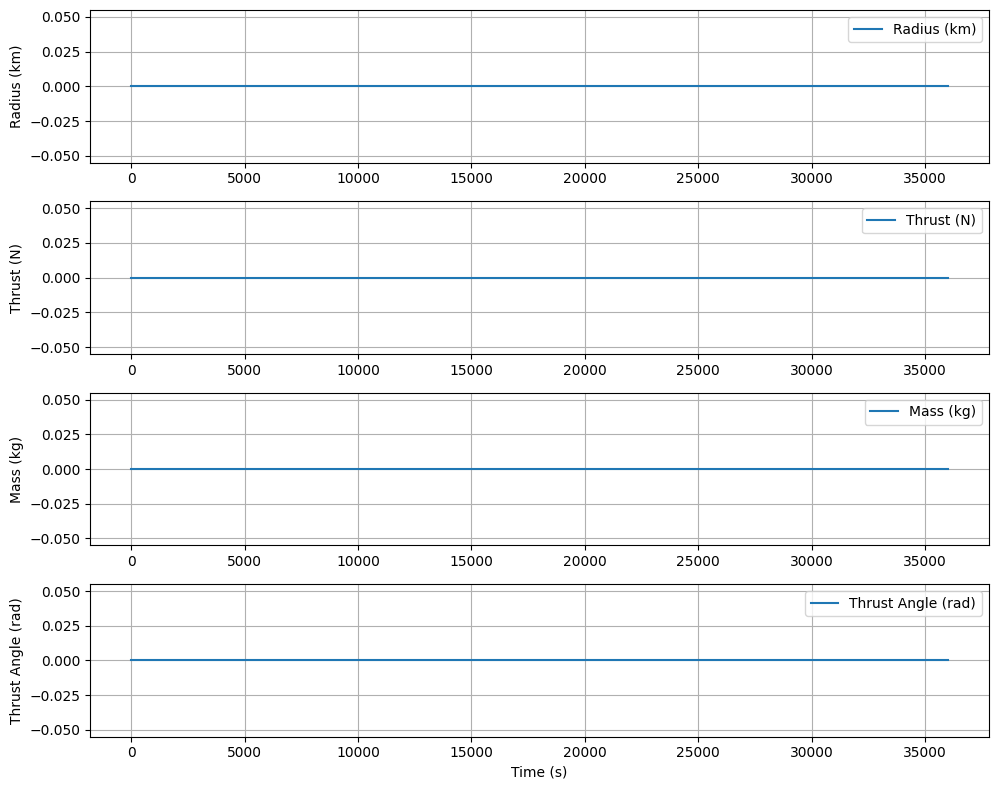

In [19]:

# Define variables
flag_savefig = False  # Set to True if you want to save the figure
savefig_dir = "./"  # Directory to save the figure

# Plot results
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(time, r / 1e6, label="Radius (km)")
plt.ylabel("Radius (km)")
plt.grid()
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time, T, label="Thrust (N)")
plt.ylabel("Thrust (N)")
plt.grid()
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time, m, label="Mass (kg)")
plt.ylabel("Mass (kg)")
plt.grid()
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time, beta, label="Thrust Angle (rad)")
plt.ylabel("Thrust Angle (rad)")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()

plt.tight_layout()

if flag_savefig:
    plt.savefig(savefig_dir + "results.png")

plt.show()
